In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/ISIC2018/train/'
test_dir = 'data/ISIC2018/test/'
test_dir_whithout_aug = "data/ISIC2018/test_without_aug/"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


In [5]:
output_classes = 7
batch_size = 8

img_height, img_width = 300, 225
input_shape = (img_height, img_width, 3)
epochs = 50

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir_whithout_aug):
    print (root, len(files))

data/ISIC2018/train/ 0
data/ISIC2018/train/DF 4152
data/ISIC2018/train/VASC 3488
data/ISIC2018/train/MEL 3308
data/ISIC2018/train/AKIEC 3856
data/ISIC2018/train/BKL 3275
data/ISIC2018/train/BCC 4773
data/ISIC2018/train/NV 4975
******************************
data/ISIC2018/test/ 0
data/ISIC2018/test/DF 1632
data/ISIC2018/test/VASC 1484
data/ISIC2018/test/MEL 1664
data/ISIC2018/test/AKIEC 1552
data/ISIC2018/test/BKL 1479
data/ISIC2018/test/BCC 1692
data/ISIC2018/test/NV 1730
******************************
data/ISIC2018/test_without_aug/ 0
data/ISIC2018/test_without_aug/DF 30
data/ISIC2018/test_without_aug/VASC 33
data/ISIC2018/test_without_aug/MEL 312
data/ISIC2018/test_without_aug/AKIEC 74
data/ISIC2018/test_without_aug/BKL 284
data/ISIC2018/test_without_aug/BCC 139
data/ISIC2018/test_without_aug/NV 1730


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 20872 images belonging to 7 classes.
Found 6955 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 20872
nb_validation_samples: 6955

predict_size_train: 2609
predict_size_validation: 870
nb_test_without_aug_samples: 2602
predict_size_test_without_aug_samples: 326
nb_test_samples: 11233
predict_size_test: 1405

 num_classes: 7


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
model = Sequential()
model.add(layers.SeparableConv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.SeparableConv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.SeparableConv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(output_classes, activation=tf.nn.softmax))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 296, 221, 32)      203       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 110, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 144, 106, 64)      2912      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 53, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 68, 49, 128)       9920      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 24, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 104448)            0         
__________

In [11]:
# adam_opt = Adam(lr=0.0001, decay=1e-5)
adam_opt=Adam(lr=0.0001, beta_1=0.6, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
2609/2609 [==============================] - 640s 245ms/step - loss: 1.7450 - acc: 0.2862 - val_loss: 1.5338 - val_acc: 0.3615
Epoch 2/50
2609/2609 [==============================] - 627s 240ms/step - loss: 1.4319 - acc: 0.4381 - val_loss: 1.3394 - val_acc: 0.4698
Epoch 3/50
2609/2609 [==============================] - 666s 255ms/step - loss: 1.3068 - acc: 0.4949 - val_loss: 1.1626 - val_acc: 0.5798
Epoch 4/50
2609/2609 [==============================] - 667s 256ms/step - loss: 1.1974 - acc: 0.5390 - val_loss: 1.0514 - val_acc: 0.6159
Epoch 5/50
2609/2609 [==============================] - 658s 252ms/step - loss: 1.1009 - acc: 0.5797 - val_loss: 0.9655 - val_acc: 0.6479
Epoch 6/50
2609/2609 [==============================] - 683s 262ms/step - loss: 1.0062 - acc: 0.6245 - val_loss: 0.9026 - val_acc: 0.6678
Epoch 7/50
2609/2609 [==============================] - 654s 251ms/step - loss: 0.9291 - acc: 0.6498 - val_loss: 0.8507 - val_acc: 0.6861
Epoch 8/50
2609/2609 [============

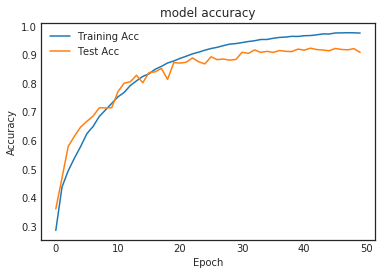

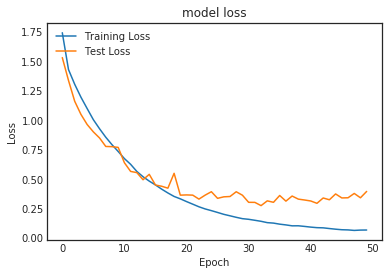

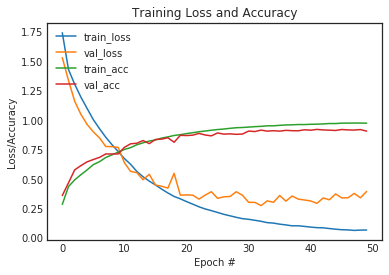

In [13]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.0969725571386516
Validation Accuracy:  0.97


In [15]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=2)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

No of errors = 2609/11233


Confusion Matrix
[[1133  193   88   69   41   27    1]
 [  21 1500   36   65   18   25   27]
 [  31   76 1154   33   59  124    2]
 [  29  163   65 1298   26   45    6]
 [  25   62  144   24 1048  354    7]
 [  18   45  106   30   77 1438   16]
 [  11  281   40   22   10   67 1053]]


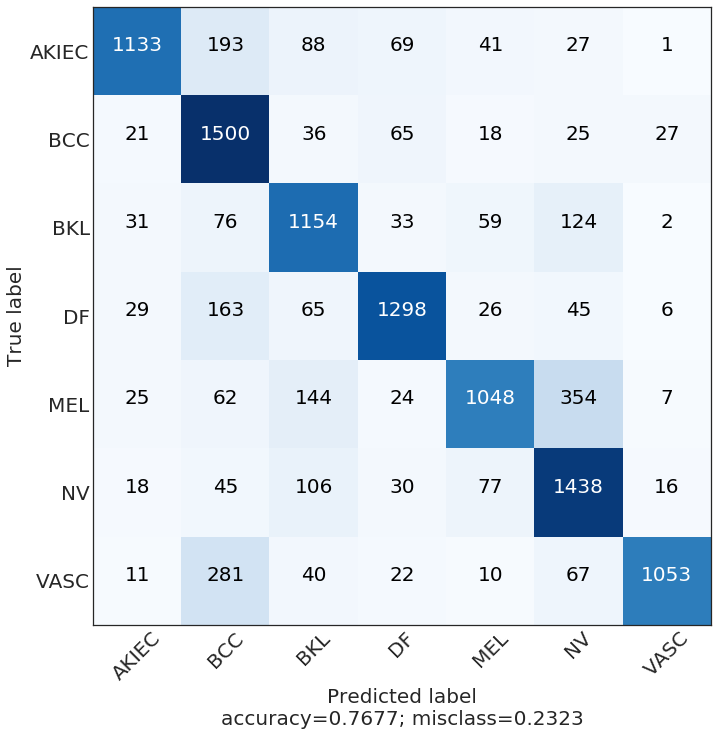

In [16]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1133  193   88   69   41   27    1]
 [  21 1500   36   65   18   25   27]
 [  31   76 1154   33   59  124    2]
 [  29  163   65 1298   26   45    6]
 [  25   62  144   24 1048  354    7]
 [  18   45  106   30   77 1438   16]
 [  11  281   40   22   10   67 1053]]
              precision    recall  f1-score   support

       AKIEC       0.89      0.73      0.80      1552
         BCC       0.65      0.89      0.75      1692
         BKL       0.71      0.78      0.74      1479
          DF       0.84      0.80      0.82      1632
         MEL       0.82      0.63      0.71      1664
          NV       0.69      0.83      0.75      1730
        VASC       0.95      0.71      0.81      1484

   micro avg       0.77      0.77      0.77     11233
   macro avg       0.79      0.77      0.77     11233
weighted avg       0.79      0.77      0.77     11233



In [18]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.23439864684412
Sensitivity :  0.9818024263431543
Specificity :  0.8860011813349085


_____

In [19]:
filename = test_generator_without_aug.filenames
truth = test_generator_without_aug.classes
label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator_without_aug, steps=test_generator_without_aug.samples/test_generator_without_aug.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator_without_aug.samples))

326/325 [==============================] - 49s 150ms/step
No of errors = 455/2602


Confusion Matrix
[[  61    5    3    2    2    1    0]
 [   0  134    1    2    0    1    1]
 [   2    9  244    5    6   18    0]
 [   0    1    0   29    0    0    0]
 [   2    8   27    2  209   63    1]
 [  18   45  106   30   77 1438   16]
 [   0    0    0    0    0    1   32]]


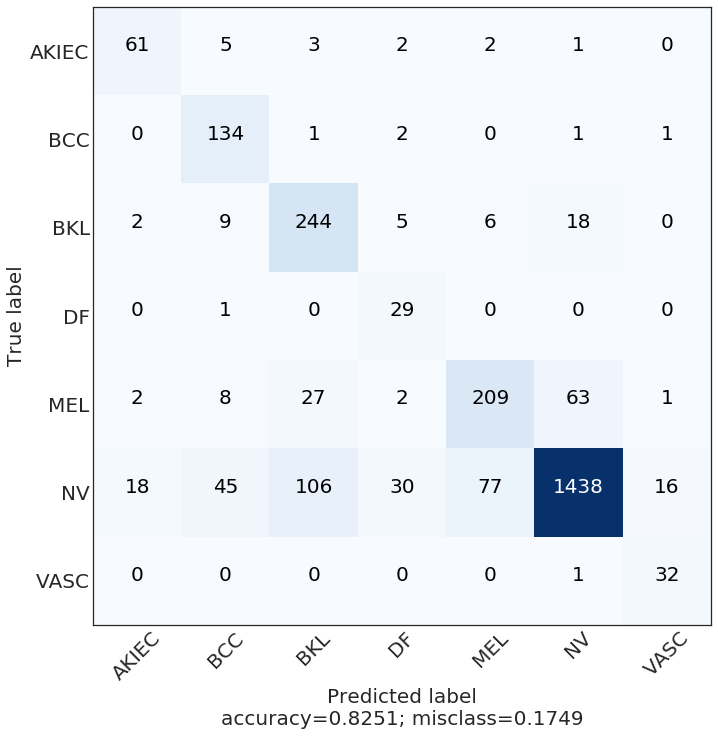

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator_without_aug.classes

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  61    5    3    2    2    1    0]
 [   0  134    1    2    0    1    1]
 [   2    9  244    5    6   18    0]
 [   0    1    0   29    0    0    0]
 [   2    8   27    2  209   63    1]
 [  18   45  106   30   77 1438   16]
 [   0    0    0    0    0    1   32]]
              precision    recall  f1-score   support

       AKIEC       0.73      0.82      0.78        74
         BCC       0.66      0.96      0.79       139
         BKL       0.64      0.86      0.73       284
          DF       0.41      0.97      0.58        30
         MEL       0.71      0.67      0.69       312
          NV       0.94      0.83      0.88      1730
        VASC       0.64      0.97      0.77        33

   micro avg       0.83      0.83      0.83      2602
   macro avg       0.68      0.87      0.75      2602
weighted avg       0.85      0.83      0.83      2602



In [22]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  1.0
Specificity :  0.9640287769784173
